In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.tabular import *

In [4]:
from google.colab import drive
drive.mount('/gdrive')

gdrive_path = '/gdrive/My Drive/Colab Notebooks/'
Config.DEFAULT_CONFIG_PATH = gdrive_path + 'fastai/config.yml'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [0]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [6]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [7]:
n = len(train_df); n

844338

### Experimenting with a sample

In [0]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [9]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
279,280,5,"Mar,Jun,Sept,Dec",18640.0,51,8189
649,651,5,NaN,200.0,61,8687
1772,661,4,NaN,2140.0,56,6335
2035,925,4,"Jan,Apr,Jul,Oct",470.0,60,7307
2291,66,3,"Jan,Apr,Jul,Oct",7660.0,73,7050


In [10]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
429004,400,1,"Jan,Apr,Jul,Oct",70.0,83,7626
429237,635,1,NaN,27530.0,69,4464
429883,139,6,"Jan,Apr,Jul,Oct",1700.0,73,4100
430276,535,6,NaN,3570.0,77,5140
430642,903,6,NaN,7290.0,73,11059


In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [12]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
429004,NaN,1,"Jan,Apr,Jul,Oct",70.0,83,7626
429237,NaN,1,NaN,27530.0,69,4464
429883,139,6,"Jan,Apr,Jul,Oct",1700.0,73,4100
430276,NaN,6,NaN,3570.0,77,5140
430642,NaN,6,NaN,7290.0,73,11059


In [13]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [14]:
small_train_df['PromoInterval'].cat.codes[:5]

279     2
649    -1
1772   -1
2035    1
2291    1
dtype: int8

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [16]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
46173,291,6,NaN,2290.0,78,3982,True
72741,622,5,NaN,2290.0,61,4926,True
245672,622,2,NaN,2290.0,89,3369,True
288601,291,3,NaN,2290.0,86,8418,True
389659,291,3,NaN,2290.0,65,9377,True
398100,879,1,"Feb,May,Aug,Nov",2290.0,86,5459,True


### Preparing full data set

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [18]:
len(train_df),len(test_df)

(844338, 41088)

In [0]:
procs=[FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [22]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [23]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

In [25]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [27]:
doc(FloatList)

## Model

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [30]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [31]:
len(data.train_ds.cont_names)

16

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


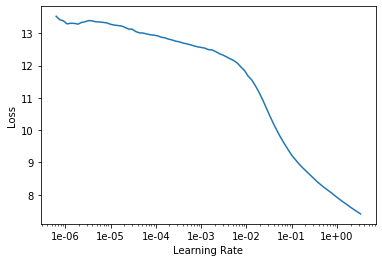

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.027231,0.037022,0.172366,02:31
1,0.019734,0.019883,0.133039,02:32
2,0.016755,0.019118,0.117361,02:32
3,0.013011,0.016345,0.114400,02:32
4,0.010733,0.011799,0.103750,02:32


In [0]:
learn.save('1')

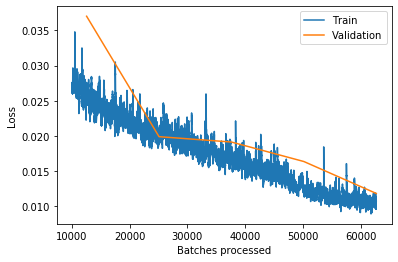

In [36]:
learn.recorder.plot_losses(skip_start=10000)

In [0]:
learn.load('1');

In [38]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011905,0.012105,0.111498,02:32
1,0.011996,0.022013,0.110114,02:32
2,0.010787,0.052189,0.131353,02:33
3,0.009827,0.013767,0.113307,02:33
4,0.008801,0.016599,0.122201,02:33


In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.011840,0.013236,0.110483
2,0.010765,0.057664,0.129586
3,0.010101,0.042744,0.111584
4,0.008820,0.116893,0.135458
5,0.009144,0.017969,0.126323


(10th place in the competition was 0.108)

In [45]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv(Config.data_path()/f"/rossmann/rossmann_submission.csv",index=False)

       index     Id  Store  ...  StateHoliday_fw Promo_fw         Sales
0          0      1      1  ...              0.0      1.0   4460.691406
1          1      2      3  ...              0.0      1.0   6949.122559
2          2      3      7  ...              0.0      1.0   9081.421875
3          3      4      8  ...              0.0      1.0   7009.385254
4          4      5      9  ...              0.0      1.0   7349.009766
...      ...    ...    ...  ...              ...      ...           ...
41083  41083  41084   1111  ...              0.0      5.0   2903.575439
41084  41084  41085   1112  ...              0.0      5.0   7290.122559
41085  41085  41086   1113  ...              0.0      5.0   6191.267090
41086  41086  41087   1114  ...              0.0      5.0  21782.144531
41087  41087  41088   1115  ...              0.0      5.0   7446.267578

[41088 rows x 93 columns]
